<a href="https://colab.research.google.com/github/Nandhinichinnathambi/FAKE-NEWS-DETECTION-USING-MACHINE-LEARNING-AND-DEEP-LEARNING-TECHNIQUES/blob/main/Main%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import re
import string
import nltk
from nltk.corpus import stopwords
from mpl_toolkits.mplot3d import Axes3D

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Load and preprocess data
df_fake = pd.read_csv('dataset fake.csv', encoding='latin1')
df_true = pd.read_csv('ARTICLES.csv', encoding='latin1')

df_fake["class"] = 0
df_true["class"] = 1

df_merge = pd.concat([df_fake, df_true], axis=0)
df_merge = df_merge.sample(frac=1).reset_index(drop=True)

df = df_merge.drop(["title", "date"], axis=1)
df["text"] = df["text"].astype(str)
df["text"] = df["text"].apply(lambda x: re.sub(r'\[.*?\]', '', x))
df["text"] = df["text"].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', '', x))
df["text"] = df["text"].apply(lambda x: re.sub(r'<.*?>+', '', x))
df["text"] = df["text"].apply(lambda x: re.sub(r'[%s]' % re.escape(string.punctuation), '', x))
df["text"] = df["text"].apply(lambda x: re.sub(r'\n', '', x))
df["text"] = df["text"].apply(lambda x: re.sub(r'\w*\d\w*', '', x))
df["text"] = df["text"].apply(lambda x: x.lower())

In [ ]:
df_fake.head()

,title,text,date,class
0,NASA Confirms Earth Will Experience 15 Days of...,NASA has announced that Earth will face 15 day...,"February 6, 2024",0
1,"Aliens Contact Earth, NASA Hides Proof",A leaked NASA document reveals that extraterre...,"February 3, 2025",0
2,"New Law Bans Cash, Digital-Only Payments Begin",The government has secretly passed a law banni...,"February 6, 2025",0
3,"Scientists Find Cure for Aging, Available Soon",A private biotech company has claimed to devel...,"February 10, 2025",0
4,"Google AI Gains Consciousness, Shuts Down Servers",Reports suggest Google's advanced AI system ha...,"February 12, 2025",0


In [ ]:
df_true.head(5)

,title,text,date,class
0,Election Commission can investigate AIADMK int...,O. Panneerselvam's supporters had approached t...,12-Feb-25,1
1,The Iron Age began from the Tamil land - Chief...,Chief Minister M.K. Stalin released the book '...,23-Jan-25,1
2,AIADMK turned Tamil Nadu into a deficit state ...,A statue of the Marudhu brothers is to be erec...,22-Jan-25,1
3,Erode East by-election on February 5,Thirumagan Evera contested as an MLA from Erod...,07-Jan-25,1
4,Governor walks out of Tamil Nadu Assembly,The first session of the 2025 Legislative Asse...,06-Jan-25,1


In [ ]:
df_fake.shape, df_true.shape

((164, 4), (174, 4))

In [ ]:
# Vectorization
vectorization = TfidfVectorizer()
xv = vectorization.fit_transform(df["text"])

In [ ]:
# Dimensionality reduction for visualization
pca = PCA(n_components=3)
xv_pca = pca.fit_transform(xv.toarray())

tsne = TSNE(n_components=3, random_state=0)
xv_tsne = tsne.fit_transform(xv.toarray())

In [ ]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(xv, df["class"], test_size=0.25, random_state=0)

In [ ]:
# Handle class imbalance
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
x_train_res, y_train_res = smote.fit_resample(x_train, y_train)

In [ ]:
# Initialize models
LR = LogisticRegression()
DT = DecisionTreeClassifier()
GBC = GradientBoostingClassifier(random_state=0)
RFC = RandomForestClassifier(random_state=0)

In [ ]:
# Train models
LR.fit(x_train, y_train)
DT.fit(x_train, y_train)
GBC.fit(x_train, y_train)
RFC.fit(x_train, y_train)

RandomForestClassifier(random_state=0)

In [ ]:
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(estimator=RFC, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}


In [ ]:
# Cross-validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(LR, x_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy:", scores.mean())

Cross-Validation Accuracy: 0.9604705882352942


In [ ]:
# Ensemble model
from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(estimators=[
    ('lr', LR),
    ('dt', DT),
    ('gbc', GBC),
    ('rfc', RFC)
], voting='hard')
ensemble.fit(x_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('dt', DecisionTreeClassifier()),
                             ('gbc',
                              GradientBoostingClassifier(random_state=0)),
                             ('rfc', RandomForestClassifier(random_state=0))])

In [ ]:
# Predictions
y_pred_lr = LR.predict(x_test)
y_pred_dt = DT.predict(x_test)
y_pred_gbc = GBC.predict(x_test)
y_pred_rfc = RFC.predict(x_test)

In [ ]:
# Evaluation metrics
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Fake News', 'Real News']))

print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt, target_names=['Fake News', 'Real News']))

print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gbc, target_names=['Fake News', 'Real News']))

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rfc, target_names=['Fake News', 'Real News']))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

   Fake News       0.97      0.97      0.97        40
   Real News       0.98      0.98      0.98        45

    accuracy                           0.98        85
   macro avg       0.98      0.98      0.98        85
weighted avg       0.98      0.98      0.98        85

Decision Tree Classification Report:
              precision    recall  f1-score   support

   Fake News       0.81      0.88      0.84        40
   Real News       0.88      0.82      0.85        45

    accuracy                           0.85        85
   macro avg       0.85      0.85      0.85        85
weighted avg       0.85      0.85      0.85        85

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

   Fake News       0.89      0.97      0.93        40
   Real News       0.98      0.89      0.93        45

    accuracy                           0.93        85
   macr

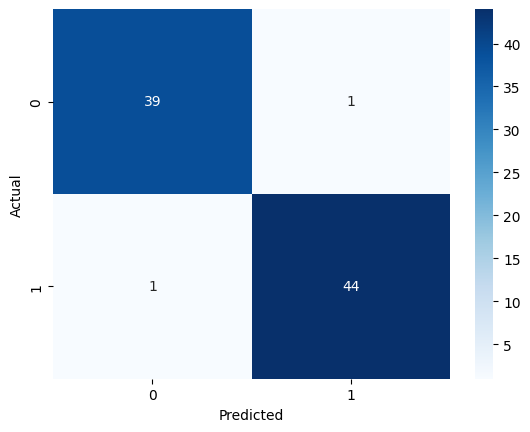

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

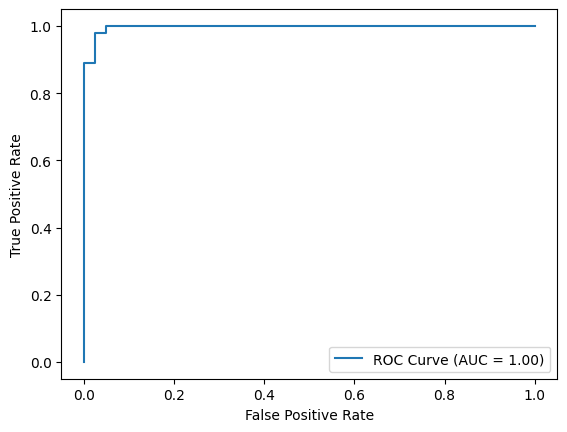

In [ ]:
# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, LR.predict_proba(x_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
# Visualization functions
def plot_3d(X, y, title, labels=None):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis', s=50)
    ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    if labels is not None:
        legend = ax.legend(*scatter.legend_elements(), title="Classes")
        ax.add_artist(legend)
    plt.show()

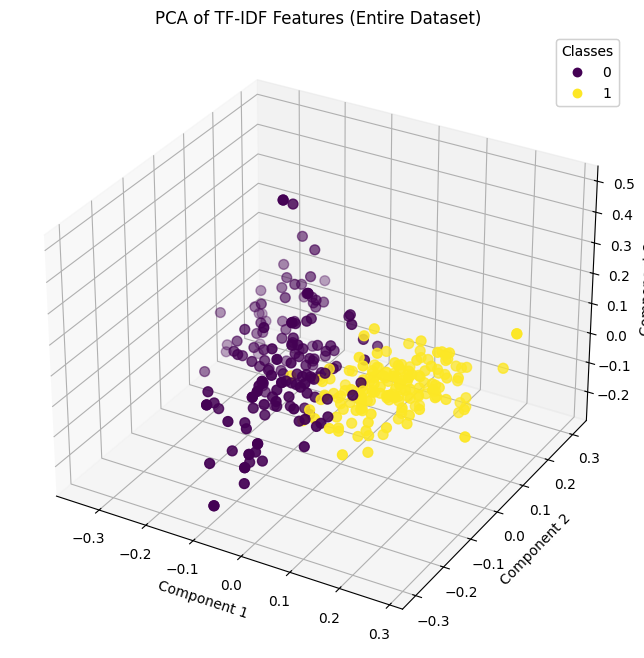

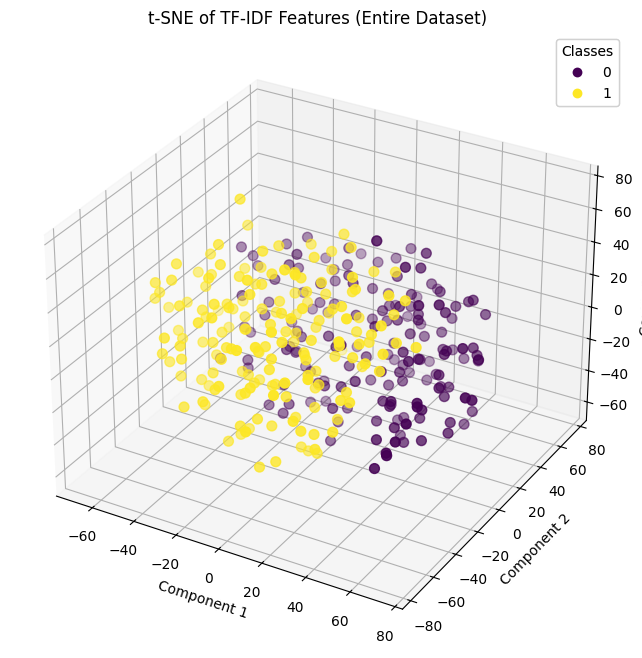

In [ ]:
# Visualizations
plot_3d(xv_pca, df["class"], "PCA of TF-IDF Features (Entire Dataset)", labels=["Fake News", "Real News"])
plot_3d(xv_tsne, df["class"], "t-SNE of TF-IDF Features (Entire Dataset)", labels=["Fake News", "Real News"])

In [ ]:
# Test data transformations
xv_test_pca = pca.transform(x_test.toarray())
xv_test_tsne = tsne.fit_transform(x_test.toarray())

In [ ]:
import plotly.express as px
import pandas as pd
pca_df = pd.DataFrame({
    'PC1': xv_pca[:len(y_train), 0],
    'PC2': xv_pca[:len(y_train), 1],
    'PC3': xv_pca[:len(y_train), 2],
    'Label': y_train.map({0: 'Fake News', 1: 'True News'}),
})

# Create interactive plot
fig = px.scatter_3d(
    pca_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Label',
    color_discrete_map={'Fake News': 'red', 'True News': 'blue'},
    # hover_name='Text',  # Remove or replace 'Text' if not available in pca_df
    opacity=0.8,
    title='Interactive 3D Visualization of News Articles'
)

# Customize layout
fig.update_layout (
    scene=dict(
        xaxis_title='PCA Component 1',
        yaxis_title='PCA Component 2',
        zaxis_title='PCA Component 3'
    ),
    margin=dict(l=0, r=0, b=0, t=30),
    legend=dict(
        title_font=dict(size=10),
        font=dict(size=12)
)
)
# Add dropdown menu for rotation control
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            buttons=[
                dict(label="Rotate",
                     method="animate",
                     args=[None]),
            ],
            direction="left",
            pad={"r": 10, "t": 10},
            showactive=False,
            x=0.1,
            xanchor="right",
            y=1.1,
            yanchor="top"
        )
    ]
)

fig.show()

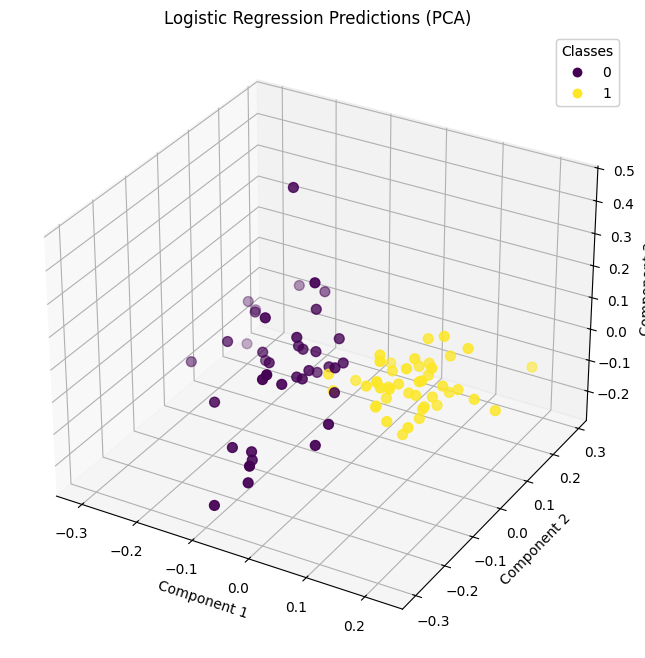

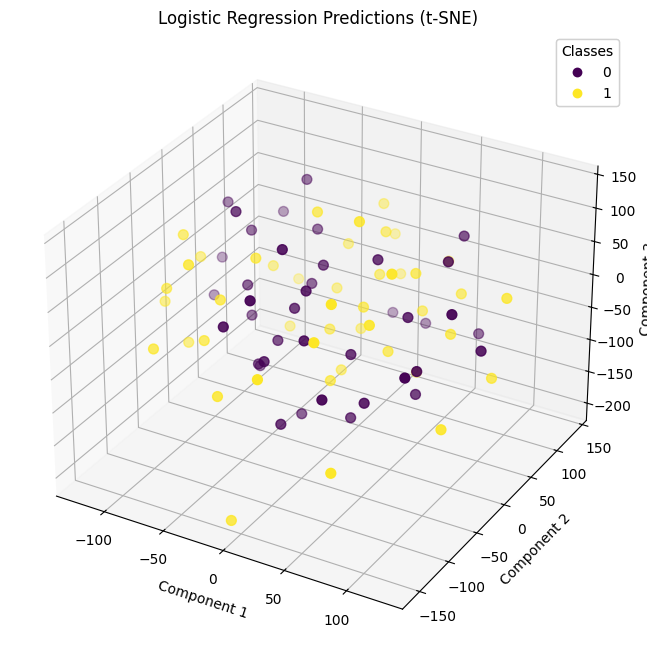

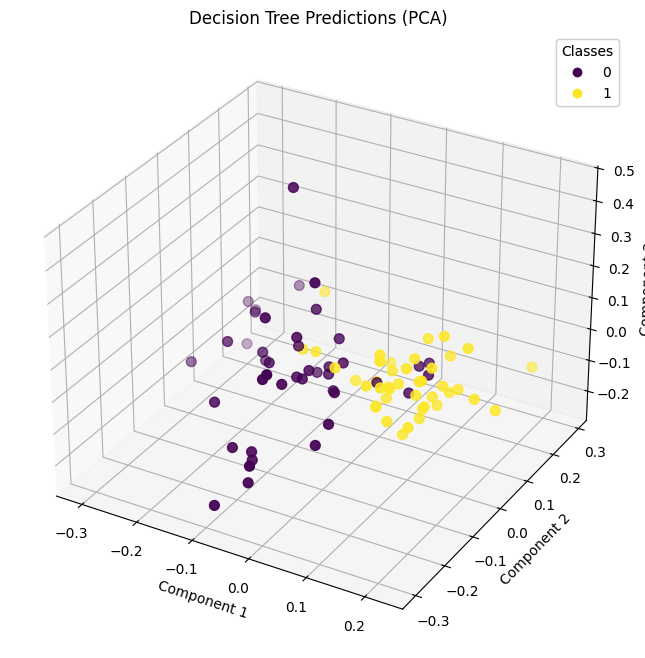

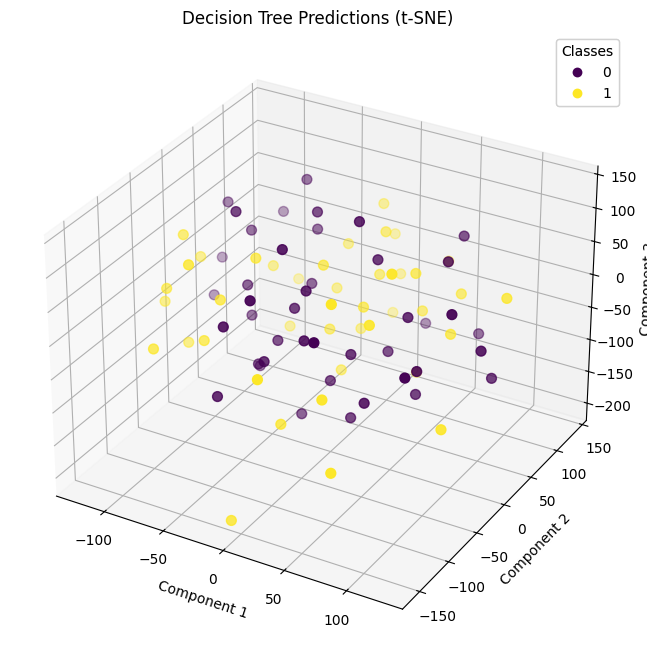

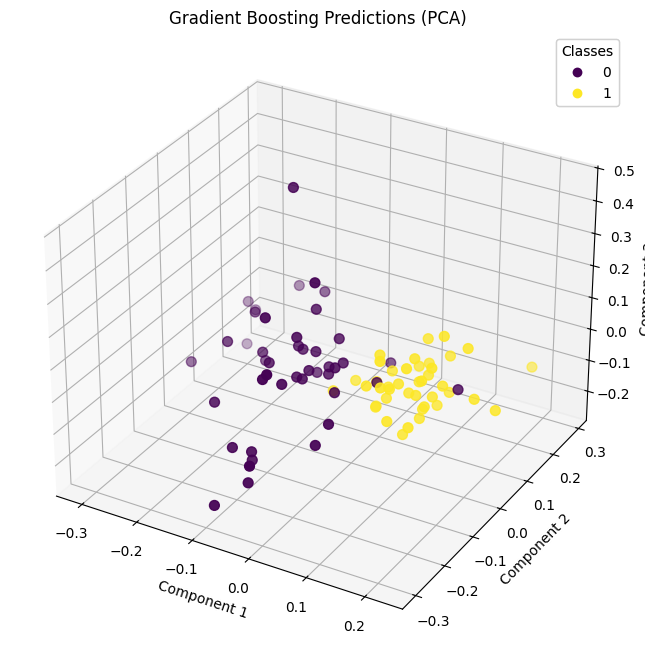

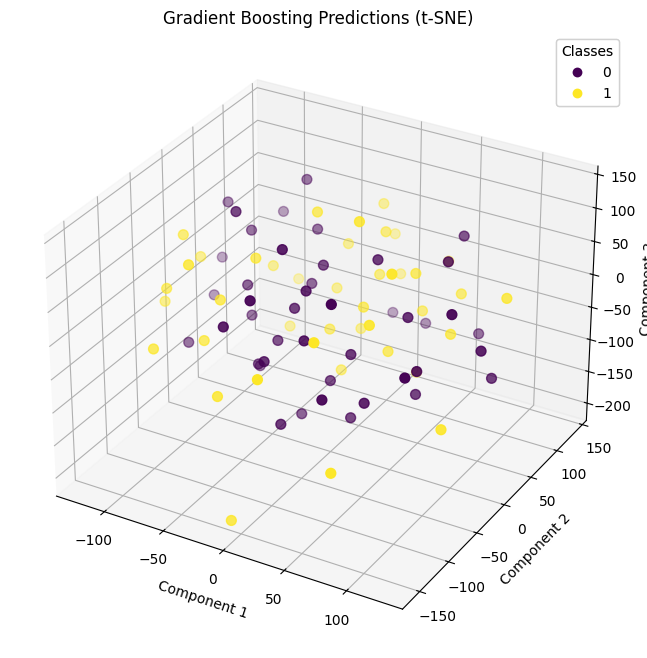

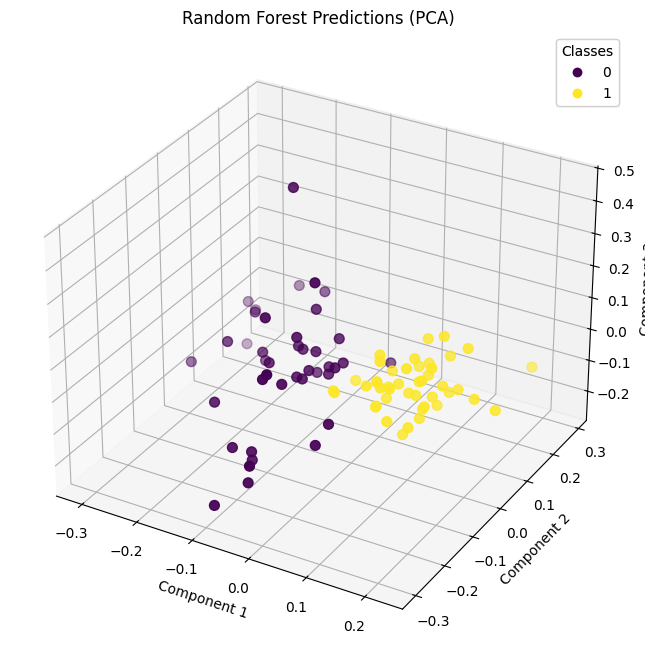

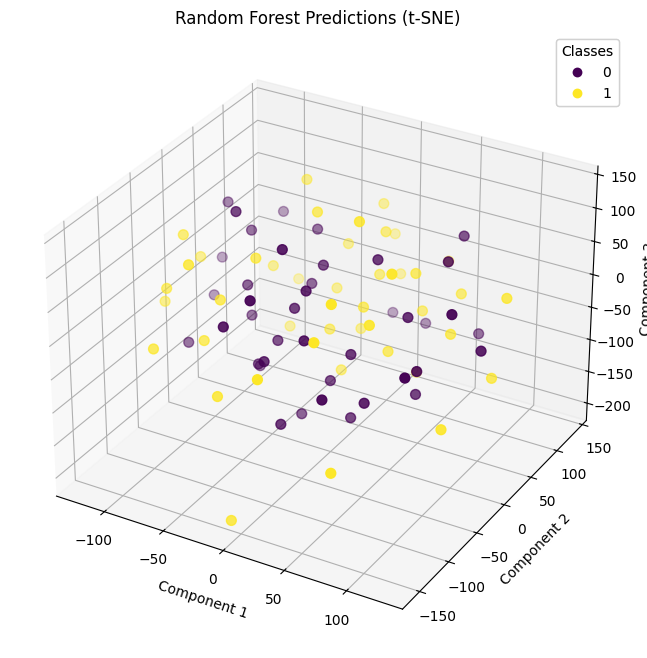

In [ ]:
# Prediction visualizations
plot_3d(xv_test_pca, y_pred_lr, "Logistic Regression Predictions (PCA)", labels=["Fake News", "Real News"])
plot_3d(xv_test_tsne, y_pred_lr, "Logistic Regression Predictions (t-SNE)", labels=["Fake News", "Real News"])
plot_3d(xv_test_pca, y_pred_dt, "Decision Tree Predictions (PCA)", labels=["Fake News", "Real News"])
plot_3d(xv_test_tsne, y_pred_dt, "Decision Tree Predictions (t-SNE)", labels=["Fake News", "Real News"])
plot_3d(xv_test_pca, y_pred_gbc, "Gradient Boosting Predictions (PCA)", labels=["Fake News", "Real News"])
plot_3d(xv_test_tsne, y_pred_gbc, "Gradient Boosting Predictions (t-SNE)", labels=["Fake News", "Real News"])
plot_3d(xv_test_pca, y_pred_rfc, "Random Forest Predictions (PCA)", labels=["Fake News", "Real News"])
plot_3d(xv_test_tsne, y_pred_rfc, "Random Forest Predictions (t-SNE)", labels=["Fake News", "Real News"])

In [ ]:
# Manual testing function
def manual_testing_with_visualization(news):
    testing_news = {"text": [news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(lambda x: re.sub(r'\[.*?\]', '', x))
    new_def_test["text"] = new_def_test["text"].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', '', x))
    new_def_test["text"] = new_def_test["text"].apply(lambda x: re.sub(r'<.*?>+', '', x))
    new_def_test["text"] = new_def_test["text"].apply(lambda x: re.sub(r'[%s]' % re.escape(string.punctuation), '', x))
    new_def_test["text"] = new_def_test["text"].apply(lambda x: re.sub(r'\n', '', x))
    new_def_test["text"] = new_def_test["text"].apply(lambda x: re.sub(r'\w*\d\w*', '', x))
    new_def_test["text"] = new_def_test["text"].apply(lambda x: x.lower())

    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)

    pred_LR = LR.predict(new_xv_test)
    pred_DT = DT.predict(new_xv_test)
    pred_GBC = GBC.predict(new_xv_test)
    pred_RFC = RFC.predict(new_xv_test)

    def output_label(prediction):
        return "Fake News" if prediction == 0 else "Real News"

    print(f"\n\nLR Prediction: {output_label(pred_LR[0])} \nDT Prediction: {output_label(pred_DT[0])} \nGBC Prediction: {output_label(pred_GBC[0])} \nRFC Prediction: {output_label(pred_RFC[0])}")

    predictions = [output_label(pred_LR[0]), output_label(pred_DT[0]), output_label(pred_GBC[0]), output_label(pred_RFC[0])]
    models = ['Logistic Regression', 'Decision Tree', 'Gradient Boosting', 'Random Forest']

    plt.figure(figsize=(10, 6))
    sns.barplot(x=models, y=[1, 1, 1, 1], hue=predictions, palette='viridis', dodge=False)
    plt.title('Model Predictions for Manual Testing')
    plt.ylabel('Count')
    plt.legend(title='Prediction')
    plt.show()

Enter the news text: Chief Minister M.K. Stalin released the book 'Irumpin Thonmai' (Antiquity of Iron) on behalf of the Department of Archaeology at the Anna Centenary Library Gallery in Kotturpuram, Chennai. Following this, he laid the foundation stone for the Keezhadi Open Air Museum and the Gangaikonda Cholapuram Museum and also launched the Keezhadi website.


LR Prediction: Real News 
DT Prediction: Real News 
GBC Prediction: Real News 
RFC Prediction: Real News


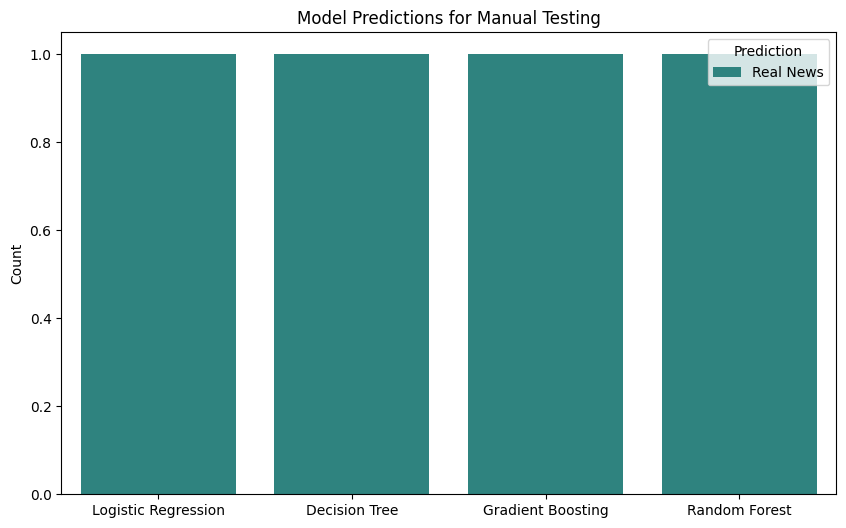

In [ ]:
# Example usage
news = str(input("Enter the news text: "))
manual_testing_with_visualization(news)

Enter the news text: The government has secretly passed a law banning cash transactions, forcing citizens to use digital payments. Critics argue this is an attempt to control finances and monitor personal spending.


LR Prediction: Fake News 
DT Prediction: Fake News 
GBC Prediction: Fake News 
RFC Prediction: Fake News


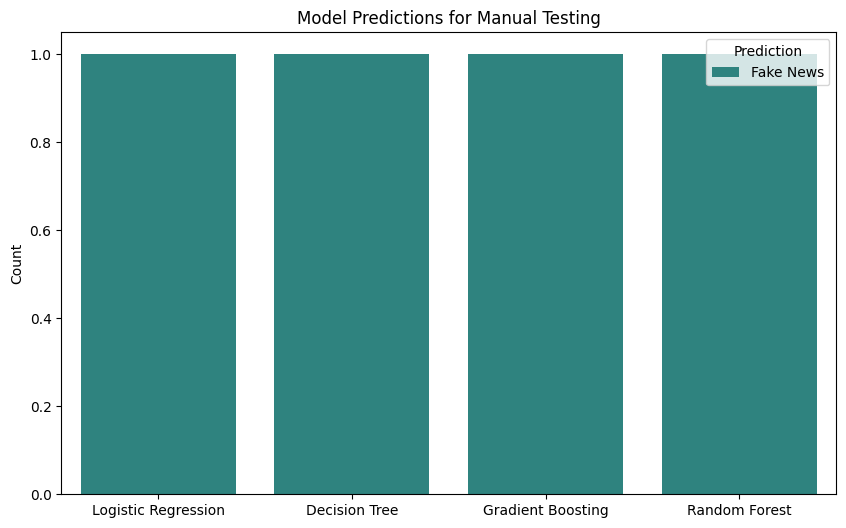

In [ ]:
# Example usage
news = str(input("Enter the news text: "))
manual_testing_with_visualization(news)

Enter the news text: Climate scientists have predicted that 2025 will be the hottest year on record, with global temperatures rising to dangerous levels. The government is said to be preparing for massive disruptions.


LR Prediction: Fake News 
DT Prediction: Fake News 
GBC Prediction: Fake News 
RFC Prediction: Fake News


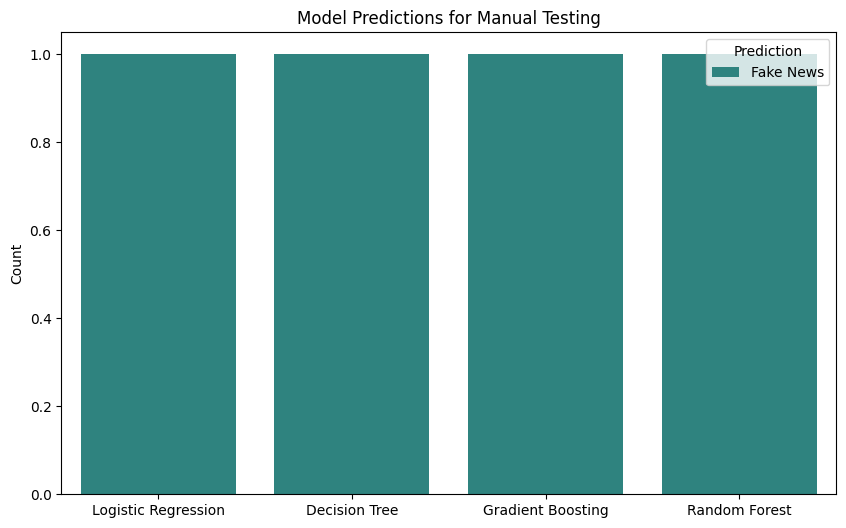

In [ ]:
# Example usage
news = str(input("Enter the news text: "))
manual_testing_with_visualization(news)

Enter the news text: ipl 2025, cancelled


LR Prediction: Fake News 
DT Prediction: Fake News 
GBC Prediction: Fake News 
RFC Prediction: Fake News


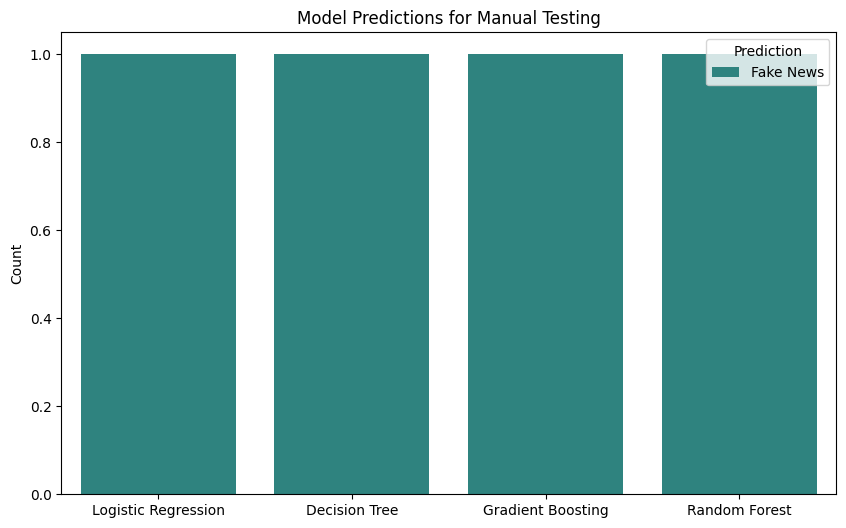

In [ ]:
# Example usage
news = str(input("Enter the news text: "))
manual_testing_with_visualization(news)

Enter the news text: Chief Minister M.K. Stalin released the book 'Irumpin Thonmai' (Antiquity of Iron) on behalf of the Department of Archaeology at the Anna Centenary Library Gallery in Kotturpuram, Chennai. Following this, he laid the foundation stone for the Keezhadi Open Air Museum and the Gangaikonda Cholapuram Museum and also launched the Keezhadi website.


LR Prediction: Real News 
DT Prediction: Real News 
GBC Prediction: Real News 
RFC Prediction: Real News


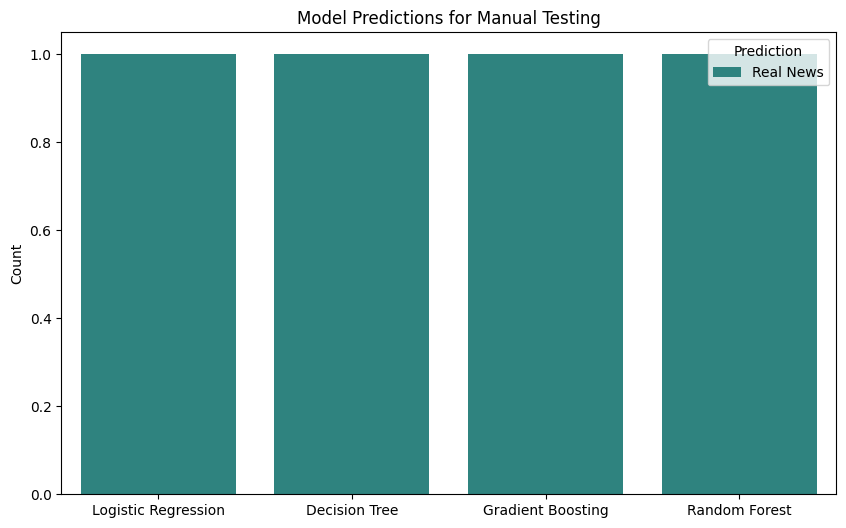

In [ ]:
# Example usage
news = str(input("Enter the news text: "))
manual_testing_with_visualization(news)

In [ ]:
# Example usage
news = str(input("Enter the news text: "))
manual_testing_with_visualization(news)